In [1]:
!gpustat

blade.seas.upenn.edu  Thu Aug  5 06:16:55 2021  455.45.01
[0] RTX A6000        | 64'C,  95 % | 44904 / 48685 MB | wangh19(44901M)
[1] RTX A6000        | 37'C,  31 % | 44884 / 48685 MB | wangh19(44881M)
[2] RTX A6000        | 28'C,   0 % |     1 / 48685 MB |
[3] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[4] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[5] RTX A6000        | 24'C,   0 % |     1 / 48685 MB |
[6] RTX A6000        | 82'C, 100 % | 46482 / 48685 MB | sifanw(46479M)
[7] RTX A6000        | 31'C,   0 % |     1 / 48685 MB |


In [2]:
!ls image_regression

Archive					  frog_colored.jpg
cookie_1.jpg				  printed_chinese_character.jpg
cookie_3.jpg				  regularized
cookie.jpg				  river_south_leather_factory.jpg
cookie_train_result_2048_0.1_color.pdf	  ucd.jpg
firework.JPG				  yulingling.JPG
firework_train_result_2048_0.1_color.pdf  yu_lin_ling_2.jpg
frog_1.jpg


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator

from jax.scipy.stats.norm import logpdf, pdf


from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [5]:
source_path = 'image_regression/'
save_path = 'image_regression/regularized/gray/'

In [6]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [7]:
from helpers import *
from regularized_image_regression_helpers import *

def d1_regularization(f):
    def pde(params, x):
        f_r = lambda x: f(params, x)[0]
        return grad(f_r)(x)
    return pde

In [8]:
key = random.PRNGKey(int(time.time()*100))

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], np.array([0.2989, 0.5870, 0.1140])).reshape(rgb.shape[:2] + (1,))
file_name = 'printed_chinese_character.jpg'
img = image.imread(source_path + file_name)
Y_raw = np.array(rgb2gray(img))
# Y_raw = np.array(img)
# Y_raw = Y_raw[::2][:,::2]
Y_raw = Y_raw[:min(Y_raw.shape[:2])][:,:min(Y_raw.shape[:2])]
Y_raw.shape

(960, 960, 1)

In [10]:
X_raw = np.array(np.meshgrid(np.arange(Y_raw.shape[0]), np.arange(Y_raw.shape[1]))).reshape(2,-1).T

In [11]:
ratio = 0.99
train_idx = random.choice(key, np.arange(X_raw.shape[0]), shape = (int(X_raw.shape[0] * ratio), ), replace = False)

X_train = X_raw[train_idx]
mu_X, sigma_X = X_train.mean(0), X_train.std(0)

Y_train = Y_raw.reshape(-1,Y_raw.shape[-1])[train_idx]
mu_Y, sigma_Y = Y_train.mean(0), Y_train.std(0)
Y_train = (Y_train - mu_Y) / sigma_Y

print(f'Ratio of pixel used: {ratio}')

Ratio of pixel used: 0.99


In [12]:
mask = np.zeros(Y_raw.shape).reshape(-1,Y_raw.shape[-1])
mask = index_update(mask, train_idx, 1).reshape(Y_raw.shape)

In [13]:
# plt.figure(figsize = (9,3))
# plt.subplot(1,3,1)
# plt.imshow(Y_raw/255, cmap = 'gray')
# plt.axis('off')
# plt.tight_layout()
# plt.subplot(1,3,2)
# plt.imshow(Y_raw * mask/255 + (1 - mask), cmap = 'gray')
# plt.axis('off')
# plt.tight_layout()
# plt.subplot(1,3,3)
# plt.imshow(Y_raw[::2][:,::2]/255, cmap = 'gray')
# plt.axis('off')
# plt.tight_layout()

# plt.savefig(save_path + file_name[:-4] + f'_three_ratio_{ratio}.pdf', dpi = 300)
# plt.show()
# plt.close()

In [14]:
batch_size = 2048
rcs_sampler = residual_sampler(batch_size, Y_raw.shape[0])

In [15]:
# For colored
width = 256
depth = 8
layers = [2, *[width for _ in range(depth)], Y_raw.shape[-1]]

activation = lambda x: np.sin(np.pi / 2 * x)
save_path = save_path + '_SIREN_'
dist = lambda key, shape: random.uniform(key, shape, minval = -np.sqrt(6), maxval = np.sqrt(6))
init_model = normInitNet(layers[:-1], activation, mu_X, sigma_X, dist = dist)

In [16]:
lr = 5e-3
init_fn, update_fn, get_params = optimizers.adam(lr)
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)
lam = 1e-4
@jit
def step(i, state, X):
    key = random.PRNGKey(i)
    g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = lam)
    return update_fn(i, g, state)
print(f'Important: confirm lam {lam} before running!!!!!!!!!!!!!!!')

Important: confirm lam 0.0001 before running!!!!!!!!!!!!!!!


In [17]:
opt_state = init_fn(init_model.scale_params)
init_nIter = 20000
pbar = trange(init_nIter)
scale_stor = []
bias_stor = []

for i in pbar:
    mini_batch = rcs_sampler.sample(random.PRNGKey(i))
    opt_state = step(i, opt_state, mini_batch)
    
    if i % 100 == 0:
        params = get_params(opt_state)
        pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), mini_batch)})
        scale_stor.append([w for (w, b) in params])
        bias_stor.append([b for (w, b) in params])
        

scale_stor = np.array(scale_stor)
bias_stor = np.array(bias_stor)
        


100%|██████████| 20000/20000 [00:46<00:00, 425.68it/s, Log sine loss=0.00059498334]


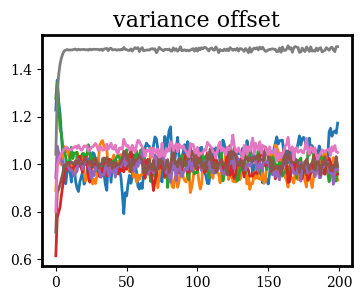

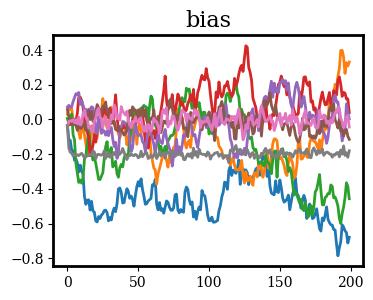

In [18]:
plt.figure(figsize = (4,3))
for i, s in enumerate(scale_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
# plt.legend()
plt.title('variance offset')
plt.show()
plt.close()

plt.figure(figsize = (4,3))
for i, s in enumerate(bias_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
# plt.legend()
plt.title('bias')
plt.show()
plt.close()

In [19]:
scale_params = params

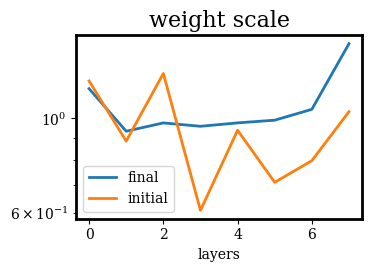

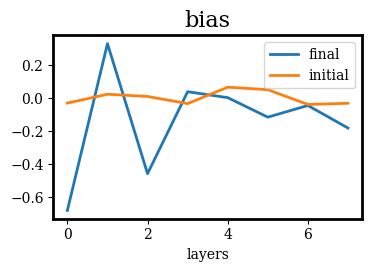

In [20]:
plt.figure(figsize = (4,3))

plt.plot([w_init for w_init, b_init in scale_params], label = 'final')
plt.plot([w_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.yscale('log')
plt.xlabel('layers')
plt.legend()
plt.title('weight scale')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (4,3))

plt.plot([b_init for w_init, b_init in scale_params], label = 'final')
plt.plot([b_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.xlabel('layers')
plt.legend()
plt.title('bias')
plt.tight_layout()

plt.show()
plt.close()

In [21]:
bcs_sampler = boundary_sampler(batch_size, X_train, Y_train)
fit_model = fitPinns(layers, activation, mu_X, sigma_X, d1_regularization, (), dist = dist)

In [22]:
fit_model.scaled_net_params = parameter_scaling(fit_model.net_params[:-1], scale_params) + [fit_model.net_params[-1]]

In [23]:
key = random.PRNGKey(int(time.time()*100))

In [24]:
# lr = 1e-3
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)

init_fn, update_fn, get_params = optimizers.adam(optimizers.exponential_decay(1e-4, decay_steps = 1000, decay_rate = 0.99))

In [25]:
nIter = 400000
losses = []
regularizer = 1e-2
more_regularizer = 1

In [26]:
@jit
def step(i, state, batch):
    g1 = grad(fit_model.boundary_loss)(get_params(state), batch[0])

    return update_fn(i, g1, state)

pbar = trange(nIter)
log = 1000
# stack the parameter trees at each leaf node for vmap
init_paramses = tree_multimap(stack_fn, fit_model.net_params, fit_model.scaled_net_params)
opt_state = vmap(init_fn)(init_paramses)
# compile the vmap optimization step
v_step = jit(vmap(step, in_axes = (None, 0, None)))
loss_stor = []

rcs_place_holder = rcs_sampler.sample(key)
for i in pbar:
    key,_ = random.split(key)
    mini_batch = (bcs_sampler.sample(key), rcs_place_holder)
    opt_state = v_step(i, opt_state, mini_batch)
    if i % log == 0:
        params = vmap(get_params)(opt_state)

        bcs_loss = vmap(fit_model.boundary_loss, in_axes = [0, None])(params, mini_batch[0])
        rcs_loss = vmap(fit_model.residual_loss, in_axes = [0, None])(params, mini_batch[1])
        loss_stor.append((bcs_loss, rcs_loss))
        
        pbar.set_postfix({'boundary loss': f'{bcs_loss[0]:.2e} {bcs_loss[1]:.2e}',\
                         'residual loss': f'{rcs_loss[0]:.2e} {rcs_loss[1]:.2e}'})
losses.append(loss_stor) 

opt_params = vmap(get_params)(opt_state)
normal_opt_params = tree_map(lambda x: x[0], opt_params)
scaled_opt_params = tree_map(lambda x: x[1], opt_params)


100%|██████████| 400000/400000 [29:02<00:00, 229.62it/s, boundary loss=3.78e-02 3.15e-02, residual loss=3.39e-01 3.58e-01] 


In [27]:
normal_pred_img = (fit_model.net_apply(normal_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)
scaled_pred_img = (fit_model.net_apply(scaled_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)

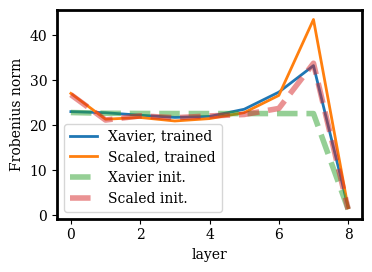

In [28]:
plt.figure(figsize = (4,3))
plt.plot(layer_weight_norm(normal_opt_params), label = 'Xavier, trained')
plt.plot(layer_weight_norm(scaled_opt_params), label = 'Scaled, trained')
plt.plot(layer_weight_norm(fit_model.net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Xavier init.')
plt.plot(layer_weight_norm(fit_model.scaled_net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Scaled init.')
plt.legend()
plt.xlabel('layer')
plt.ylabel(r'Frobenius norm')
# plt.ylim([0, 100])
plt.tight_layout()
# plt.savefig(save_path + file_name[:-4] + f'_ratio_{ratio}_norm.pdf', dpi = 300)
plt.show()
plt.close()

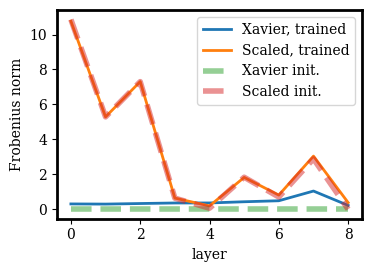

In [29]:
plt.figure(figsize = (4,3))
plt.plot(layer_bias_norm(normal_opt_params), label = 'Xavier, trained')
plt.plot(layer_bias_norm(scaled_opt_params), label = 'Scaled, trained')
plt.plot(layer_bias_norm(fit_model.net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Xavier init.')
plt.plot(layer_bias_norm(fit_model.scaled_net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Scaled init.')
plt.legend()
plt.xlabel('layer')
plt.ylabel(r'Frobenius norm')
# plt.ylim([0, 100])
plt.tight_layout()
# plt.savefig(save_path + file_name[:-4] + f'_ratio_{ratio}_norm.pdf', dpi = 300)
plt.show()
plt.close()

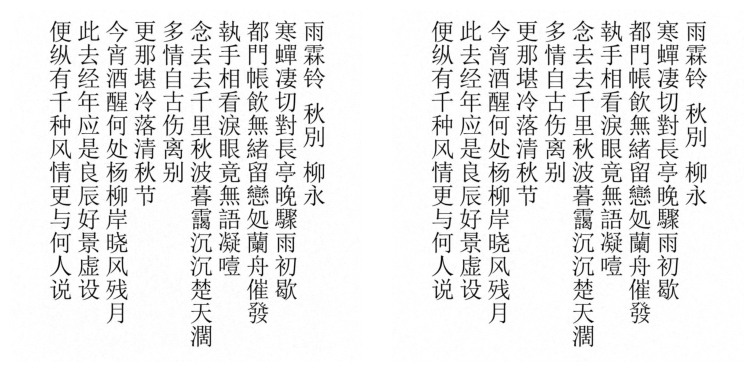

In [30]:
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.imshow(np.clip(normal_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(1,2,2)
plt.imshow(np.clip(scaled_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

In [31]:
@jit
def step(i, state, batch, w):
    g1 = grad(fit_model.boundary_loss)(get_params(state), batch[0])
    g2 = grad(fit_model.residual_loss)(get_params(state), batch[1])
    g = tree_multimap(lambda x,y: w[0] * x + y * w[1], g1, g2)
    return update_fn(i, g, state)

pbar = trange(nIter)
# stack the parameter trees at each leaf node for vmap
init_paramses = tree_multimap(stack_fn, fit_model.net_params, fit_model.scaled_net_params)
opt_state = vmap(init_fn)(init_paramses)
# compile the vmap optimization step
v_step = jit(vmap(step, in_axes = (None, 0, None, None)))
loss_stor = []
weight = [1., regularizer]
for i in pbar:
    key,_ = random.split(key)
    mini_batch = (bcs_sampler.sample(key), rcs_sampler.sample(key))
    opt_state = v_step(i, opt_state, mini_batch, weight)
    if i % log == 0:
        params = vmap(get_params)(opt_state)

        bcs_loss = vmap(fit_model.boundary_loss, in_axes = [0, None])(params, mini_batch[0])
        rcs_loss = vmap(fit_model.residual_loss, in_axes = [0, None])(params, mini_batch[1])
        loss_stor.append((bcs_loss, rcs_loss))
        
        pbar.set_postfix({'boundary loss': f'{bcs_loss[0]:.2e} {bcs_loss[1]:.2e}',\
                         'residual loss': f'{rcs_loss[0]:.2e} {rcs_loss[1]:.2e}'})
losses.append(loss_stor) 
        
opt_params = vmap(get_params)(opt_state)
regularized_normal_opt_params = tree_map(lambda x: x[0], opt_params)
regularized_scaled_opt_params = tree_map(lambda x: x[1], opt_params)

100%|██████████| 400000/400000 [46:43<00:00, 142.70it/s, boundary loss=3.82e-02 3.21e-02, residual loss=2.78e-01 2.70e-01] 


In [32]:
regularized_normal_pred_img = (fit_model.net_apply(regularized_normal_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)
regularized_scaled_pred_img = (fit_model.net_apply(regularized_scaled_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)

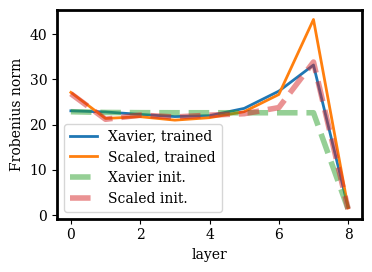

In [33]:
plt.figure(figsize = (4,3))
plt.plot(layer_weight_norm(regularized_normal_opt_params), label = 'Xavier, trained')
plt.plot(layer_weight_norm(regularized_scaled_opt_params), label = 'Scaled, trained')
plt.plot(layer_weight_norm(fit_model.net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Xavier init.')
plt.plot(layer_weight_norm(fit_model.scaled_net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Scaled init.')
plt.legend()
plt.xlabel('layer')
plt.ylabel(r'Frobenius norm')
# plt.ylim([0, 100])
plt.tight_layout()
plt.show()
plt.close()

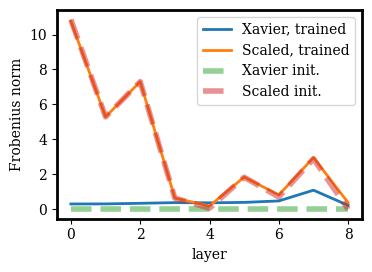

In [34]:
plt.figure(figsize = (4,3))
plt.plot(layer_bias_norm(regularized_normal_opt_params), label = 'Xavier, trained')
plt.plot(layer_bias_norm(regularized_scaled_opt_params), label = 'Scaled, trained')
plt.plot(layer_bias_norm(fit_model.net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Xavier init.')
plt.plot(layer_bias_norm(fit_model.scaled_net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Scaled init.')
plt.legend()
plt.xlabel('layer')
plt.ylabel(r'Frobenius norm')
# plt.ylim([0, 100])
plt.tight_layout()
# plt.savefig(save_path + file_name[:-4] + f'_ratio_{ratio}_norm.pdf', dpi = 300)
plt.show()
plt.close()

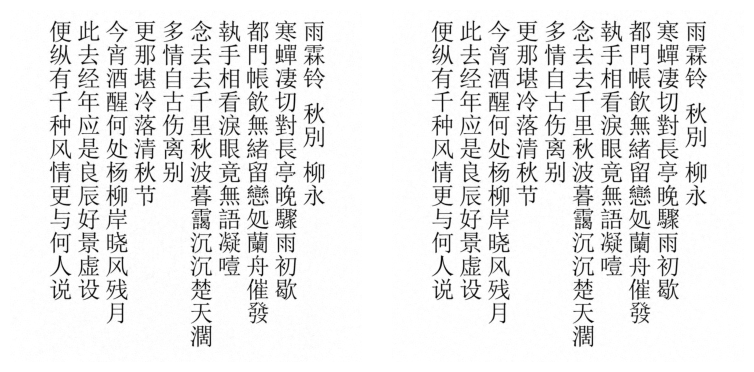

In [35]:
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.imshow(np.clip(regularized_normal_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(1,2,2)
plt.imshow(np.clip(regularized_scaled_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

In [36]:
@jit
def step(i, state, batch, w):
    g1 = grad(fit_model.boundary_loss)(get_params(state), batch[0])
    g2 = grad(fit_model.residual_loss)(get_params(state), batch[1])
    g = tree_multimap(lambda x,y: w[0] * x + y * w[1], g1, g2)
    return update_fn(i, g, state)

pbar = trange(nIter)
# stack the parameter trees at each leaf node for vmap
init_paramses = tree_multimap(stack_fn, fit_model.net_params, fit_model.scaled_net_params)
opt_state = vmap(init_fn)(init_paramses)
# compile the vmap optimization step
v_step = jit(vmap(step, in_axes = (None, 0, None, None)))
loss_stor = []
weight = [1., more_regularizer]
for i in pbar:
    key,_ = random.split(key)
    mini_batch = (bcs_sampler.sample(key), rcs_sampler.sample(key))
    opt_state = v_step(i, opt_state, mini_batch, weight)
    if i % log == 0:
        params = vmap(get_params)(opt_state)

        bcs_loss = vmap(fit_model.boundary_loss, in_axes = [0, None])(params, mini_batch[0])
        rcs_loss = vmap(fit_model.residual_loss, in_axes = [0, None])(params, mini_batch[1])
        loss_stor.append((bcs_loss, rcs_loss))
        
        pbar.set_postfix({'boundary loss': f'{bcs_loss[0]:.2e} {bcs_loss[1]:.2e}',\
                         'residual loss': f'{rcs_loss[0]:.2e} {rcs_loss[1]:.2e}'})
losses.append(loss_stor) 
        
opt_params = vmap(get_params)(opt_state)
more_regularized_normal_opt_params = tree_map(lambda x: x[0], opt_params)
more_regularized_scaled_opt_params = tree_map(lambda x: x[1], opt_params)

100%|██████████| 400000/400000 [46:31<00:00, 143.27it/s, boundary loss=1.19e-01 1.18e-01, residual loss=1.07e-01 1.08e-01] 


In [37]:
more_regularized_normal_pred_img = (fit_model.net_apply(more_regularized_normal_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)
more_regularized_scaled_pred_img = (fit_model.net_apply(more_regularized_scaled_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)

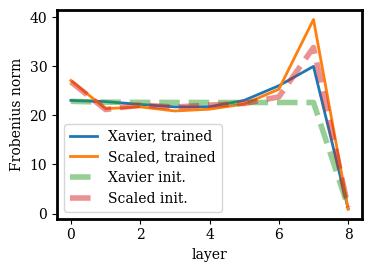

In [38]:
plt.figure(figsize = (4,3))
plt.plot(layer_weight_norm(more_regularized_normal_opt_params), label = 'Xavier, trained')
plt.plot(layer_weight_norm(more_regularized_scaled_opt_params), label = 'Scaled, trained')
plt.plot(layer_weight_norm(fit_model.net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Xavier init.')
plt.plot(layer_weight_norm(fit_model.scaled_net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Scaled init.')
plt.legend()
plt.xlabel('layer')
plt.ylabel(r'Frobenius norm')
# plt.ylim([0, 100])
plt.tight_layout()
plt.show()
plt.close()

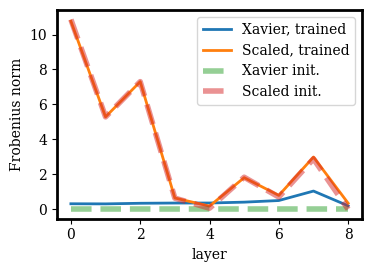

In [39]:
plt.figure(figsize = (4,3))
plt.plot(layer_bias_norm(more_regularized_normal_opt_params), label = 'Xavier, trained')
plt.plot(layer_bias_norm(more_regularized_scaled_opt_params), label = 'Scaled, trained')
plt.plot(layer_bias_norm(fit_model.net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Xavier init.')
plt.plot(layer_bias_norm(fit_model.scaled_net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Scaled init.')
plt.legend()
plt.xlabel('layer')
plt.ylabel(r'Frobenius norm')
# plt.ylim([0, 100])
plt.tight_layout()
# plt.savefig(save_path + file_name[:-4] + f'_ratio_{ratio}_norm.pdf', dpi = 300)
plt.show()
plt.close()

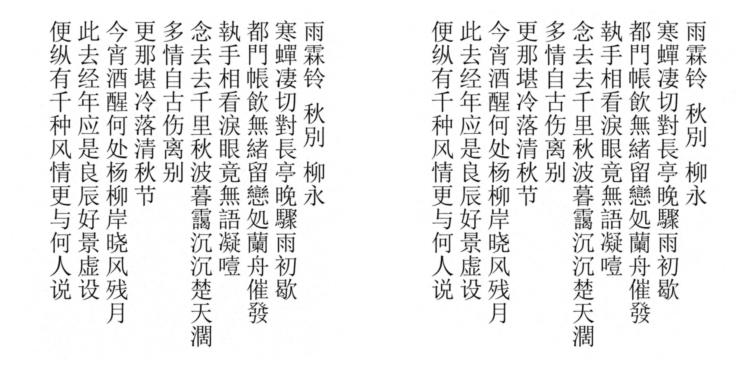

In [40]:
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.imshow(np.clip(more_regularized_normal_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(1,2,2)
plt.imshow(np.clip(more_regularized_scaled_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

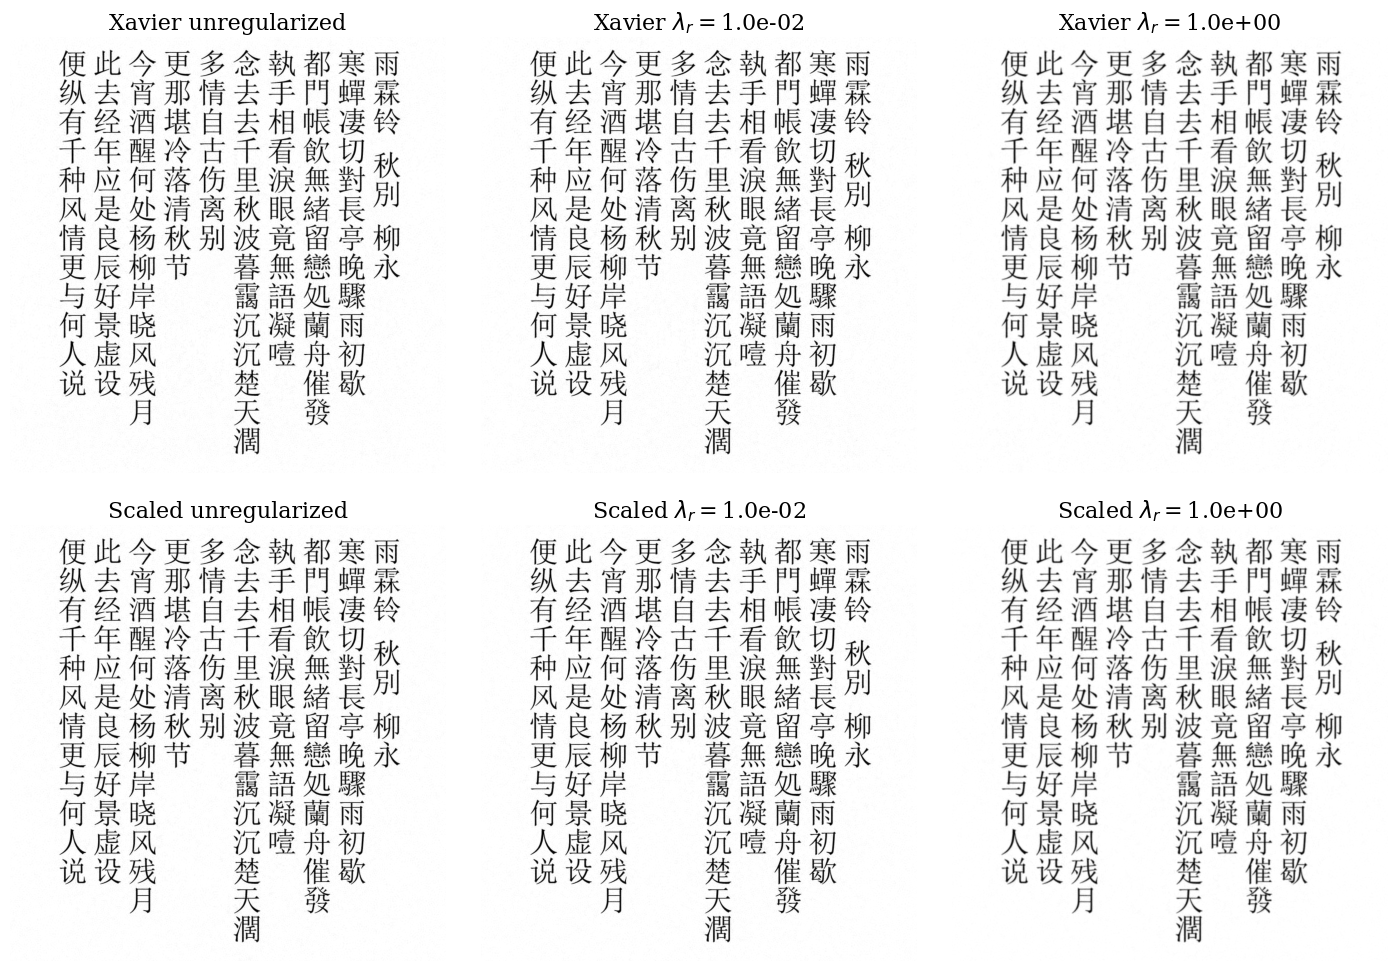

In [41]:
plt.figure(figsize = (15, 10))
plt.subplot(2,3,1)
plt.imshow(np.clip(normal_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.axis('off')
plt.title('Xavier unregularized')
plt.tight_layout()

plt.subplot(2,3,4)
plt.imshow(np.clip(scaled_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.title('Scaled unregularized')
plt.axis('off')
plt.tight_layout()

plt.subplot(2,3,2)
plt.imshow(np.clip(regularized_normal_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.axis('off')
plt.title(r'Xavier $\lambda_r = $' + f'{regularizer:.1e}')
plt.tight_layout()


plt.subplot(2,3,5)
plt.imshow(np.clip(regularized_scaled_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.title(r'Scaled $\lambda_r = $' + f'{regularizer:.1e}')
plt.axis('off')
plt.tight_layout()

plt.subplot(2,3,3)
plt.imshow(np.clip(more_regularized_normal_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.axis('off')
plt.title(r'Xavier $\lambda_r = $' + f'{more_regularizer:.1e}')
plt.tight_layout()


plt.subplot(2,3,6)
plt.imshow(np.clip(more_regularized_scaled_pred_img/255, a_min = 0, a_max = 1), cmap = 'gray')
plt.title(r'Scaled $\lambda_r = $' + f'{more_regularizer:.1e}')
plt.axis('off')
plt.tight_layout()


plt.tight_layout()
plt.savefig(save_path + file_name[:-4] + f'_width_{width}_depth_{depth}_multi_regularized_train_result_only_{batch_size}_{ratio}.pdf', dpi = 300)

plt.show()
plt.close()

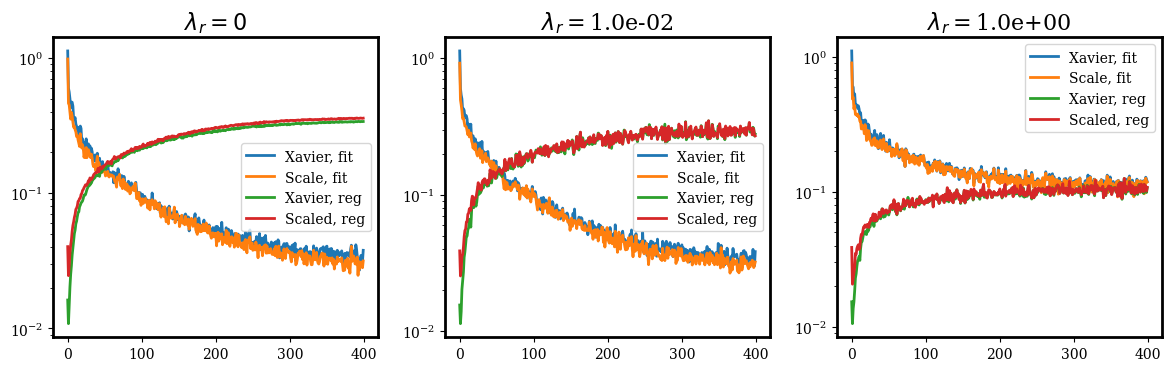

In [42]:
losses = np.array(losses)
np.save(save_path + file_name[:-4] + \
        f'_width_{width}_depth_{depth}_multi_regularized_{batch_size}_{ratio}_losses',\
        losses)

plt.figure(figsize = (12, 4))
for i, t in zip(range(3), [r'$\lambda_r = 0$', r'$\lambda_r = $' + f'{regularizer:.1e}', r'$\lambda_r = $' + f'{more_regularizer:.1e}']):
    plt.subplot(1,3,i+1)
    plt.plot(losses[i, :, 0, 0], label = 'Xavier, fit')
    plt.plot(losses[i, :, 0, 1], label = 'Scale, fit')
    plt.plot(losses[i, :, 1, 0], label = 'Xavier, reg')
    plt.plot(losses[i, :, 1, 1], label = 'Scaled, reg')
    plt.yscale('log')
    plt.legend()
    plt.title(t)
    plt.tight_layout()
    
plt.show()
plt.close()

In [43]:
np.save(save_path + file_name[:-4] + \
        f'_width_{width}_depth_{depth}_multi_regularized_{batch_size}_{ratio}_flat_params',\
        np.array((ravel_pytree(normal_opt_params)[0],\
                  ravel_pytree(scaled_opt_params)[0],\
                  ravel_pytree(regularized_normal_opt_params)[0],\
                  ravel_pytree(regularized_scaled_opt_params)[0],\
                  ravel_pytree(more_regularized_normal_opt_params)[0],\
                  ravel_pytree(more_regularized_scaled_opt_params)[0]))
                 )

In [44]:
flat_params = np.load(save_path + file_name[:-4] + \
        f'_width_{width}_depth_{depth}_multi_regularized_{batch_size}_{ratio}_flat_params.npy')
_, unravel = ravel_pytree(fit_model.scaled_net_params)

normal_opt_params = unravel(flat_params[0])
scaled_opt_params = unravel(flat_params[1])
regularized_normal_opt_params = unravel(flat_params[2])
regularized_scaled_opt_params = unravel(flat_params[3])
more_regularized_normal_opt_params = unravel(flat_params[4])
more_regularized_scaled_opt_params = unravel(flat_params[5])

normal_pred_img = (fit_model.net_apply(normal_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)
scaled_pred_img = (fit_model.net_apply(scaled_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)

regularized_normal_pred_img = (fit_model.net_apply(regularized_normal_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)
regularized_scaled_pred_img = (fit_model.net_apply(regularized_scaled_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)

more_regularized_normal_pred_img = (fit_model.net_apply(more_regularized_normal_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)
more_regularized_scaled_pred_img = (fit_model.net_apply(more_regularized_scaled_opt_params, X_raw) * sigma_Y + mu_Y).reshape(Y_raw.shape)

In [45]:
SNR = lambda pred, y: -np.log(np.linalg.norm(pred - y) / np.linalg.norm(y)) / np.log(10) * 10 * 2

print(f'SNR of Xavier initialization: {SNR(normal_pred_img, Y_raw)}, {SNR(regularized_normal_pred_img, Y_raw)}, {SNR(more_regularized_normal_pred_img, Y_raw)}')
print(f'SNR of scaled initialization: {SNR(scaled_pred_img, Y_raw)}, {SNR(regularized_scaled_pred_img, Y_raw)}, {SNR(more_regularized_scaled_pred_img, Y_raw)}')

SNR of Xavier initialization: 25.695974349975586, 25.773258209228516, 20.675853729248047
SNR of scaled initialization: 26.225460052490234, 26.22260284423828, 20.777515411376953


In [46]:
with open(save_path + file_name[:-4] + \
          f'_width_{width}_depth_{depth}_multi_regularized_{batch_size}_{ratio}_SNR.txt', "w") as text_file:
    text_file.write(f'regularization: 0, {regularizer}, {more_regularizer};\n')
    text_file.write(f'SNR of Xavier initialization: {SNR(normal_pred_img, Y_raw)}, {SNR(regularized_normal_pred_img, Y_raw)}, {SNR(more_regularized_normal_pred_img, Y_raw)};\n')
    text_file.write(f'SNR of scaled initialization: {SNR(scaled_pred_img, Y_raw)}, {SNR(regularized_scaled_pred_img, Y_raw)}, {SNR(more_regularized_scaled_pred_img, Y_raw)};\n')